# Imports

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import warnings
from data_preparation import *
import imblearn
from collections import Counter
from imblearn.under_sampling import NearMiss
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import shap

warnings.filterwarnings("ignore")

# Dataprep train dataset

In [8]:
train_prepared = pd.read_csv('./data/train_prepared.csv')
test_prepared = pd.read_csv('./data/test_prepared.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

In [9]:
train_prepared['SK_ID_CURR'] = df_app['SK_ID_CURR'].copy()

In [10]:
train_prepared['CODE_GENDER'] = train_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)
test_prepared['CODE_GENDER'] = test_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)

In [11]:
train_prepared.drop(columns = 'Unnamed: 0', inplace = True)

# Dataprep CB_balance dataset

In [12]:
pos = pd.read_csv('./data/POS_CASH_balance.csv')

In [13]:
print(f'nb lignes : {pos.shape[0]} vs nb id uniques : {pos.SK_ID_CURR.nunique()}')

nb lignes : 10001358 vs nb id uniques : 337252


In [14]:
pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [16]:
pos_mean = pos.drop(columns =['NAME_CONTRACT_STATUS','SK_ID_PREV']).groupby('SK_ID_CURR').mean()
pos_mean = pos_mean.reset_index()
#cb_mean['NAME_CONTRACT_STATUS'] = cb[['NAME_CONTRACT_STATUS','SK_ID_CURR']].groupby('SK_ID_CURR').mode()
pos_mean = pos_mean[['CNT_INSTALMENT_FUTURE','SK_ID_CURR']]

In [17]:
train_prepared = pd.merge(train_prepared,pos_mean, on = 'SK_ID_CURR')

In [18]:
pos_mean.columns

Index(['CNT_INSTALMENT_FUTURE', 'SK_ID_CURR'], dtype='object')

# NaN

In [20]:
for col in train_prepared.select_dtypes(include='number').columns:
    moyenne = train_prepared[col].mean()
    train_prepared[col] = train_prepared[col].fillna(moyenne)

# One hot encoding

In [21]:
for col in train_prepared.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(train_prepared[col], prefix=col, drop_first=True)
    train_prepared = train_prepared.drop(col, axis=1)
    train_prepared = train_prepared.join(one_hot_encoded)

for col in train_prepared.select_dtypes(include=bool).columns:
    train_prepared[col] = train_prepared[col].astype(int)
    

# Train,Test split

In [35]:
new_columns = []
for col in train_prepared.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

train_prepared.columns = new_columns


new_columns = []
for col in X_test.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_test.columns = new_columns

In [37]:
X = train_prepared[['EXT_SOURCE_2_disc_int__0_45_0_85_', 'EXT_SOURCE_3_disc_int__0_31_0_9_',
       'EXT_SOURCE_1_disc_int__0_41_0_96_', 'CODE_GENDER_M',
       'DAYS_EMPLOYED_disc_int___2443_365243_', 'CNT_INSTALMENT_FUTURE','TARGET','SK_ID_CURR']].copy()

y = train_prepared['TARGET'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#, stratify = y)
X_train.drop(columns = ['TARGET','SK_ID_CURR'],inplace =True)
X_test.drop(columns = ['TARGET','SK_ID_CURR'],inplace =True)

# Logit

In [38]:
#X_train = X_train[selected_variables_names]
#X_test = X_test[selected_variables_names]

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Matrice de confusion :")
print(conf_matrix)

Matrice de confusion :
[[53180     1]
 [ 4442     0]]


In [40]:
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.6996096456875955


# Corretion noms colonnes

In [41]:
new_columns = []
for col in X_train.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_train.columns = new_columns


new_columns = []
for col in X_test.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_test.columns = new_columns

# Xgboost

In [42]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth',3, 10),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test,y_pred,output_dict=True)
    f_one = report['1']['f1-score']
    
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    return roc_auc

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best positive auc score: {study.best_value}")


[I 2024-02-20 22:57:41,499] A new study created in memory with name: no-name-33938687-98c7-4267-b608-92a3b0f3e1a7
[I 2024-02-20 22:57:43,024] Trial 0 finished with value: 0.702987819472651 and parameters: {'max_depth': 4, 'eta': 0.23508128638127782, 'gamma': 1.5721458330340312e-05, 'colsample_bytree': 0.324800464734187, 'subsample': 0.7654472645373827, 'n_estimators': 124, 'alpha': 0.05681460197414376}. Best is trial 0 with value: 0.702987819472651.
[I 2024-02-20 22:57:43,952] Trial 1 finished with value: 0.703202472563159 and parameters: {'max_depth': 6, 'eta': 0.0752167614504688, 'gamma': 1.2990434251616702e-05, 'colsample_bytree': 0.6431935711252652, 'subsample': 0.9677722804867739, 'n_estimators': 94, 'alpha': 0.2579284945753871}. Best is trial 1 with value: 0.703202472563159.
[I 2024-02-20 22:57:44,762] Trial 2 finished with value: 0.7032338191319154 and parameters: {'max_depth': 3, 'eta': 0.307124589765976, 'gamma': 2.1118782756829837e-08, 'colsample_bytree': 0.3050973296491973, 

Best parameters: {'max_depth': 3, 'eta': 0.307124589765976, 'gamma': 2.1118782756829837e-08, 'colsample_bytree': 0.3050973296491973, 'subsample': 0.8053815194214476, 'n_estimators': 120, 'alpha': 0.32257889474392876}
Best positive auc score: 0.7032338191319154


In [28]:
report = classification_report(y_test,y_pred,output_dict=True)
report['1']['f1-score']

0.014621178555604785

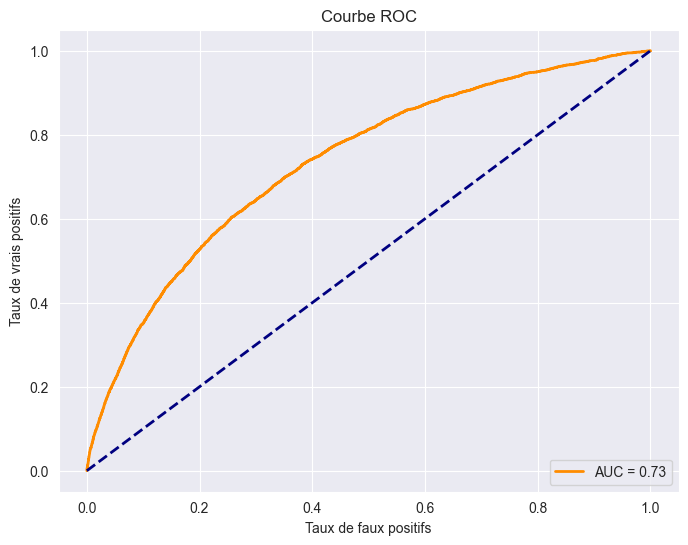

In [29]:
params = study.best_params

model = xgb.XGBClassifier(**params)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

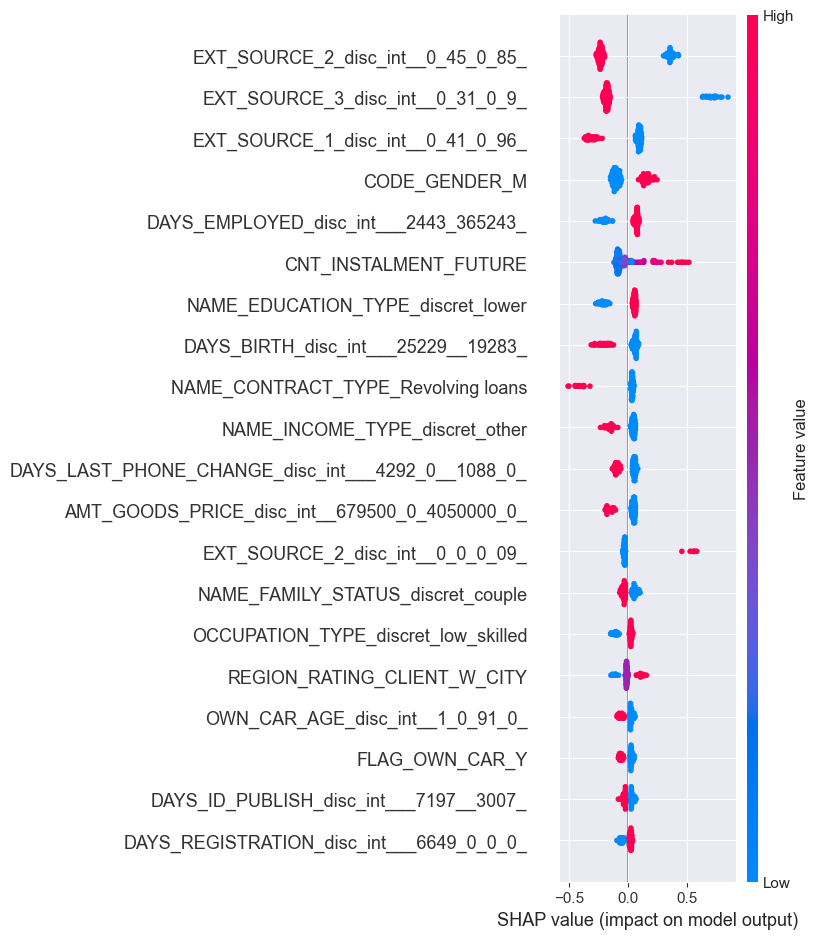

In [30]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train.iloc[:150, :])

shap.summary_plot(shap_values, X_train.iloc[:150, :])

shap_values_single = explainer.shap_values(X_train.iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[[0]])

In [32]:
import numpy as np
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]


n_top_variables = 6
top_variables = X_train.columns[top_variables_indices[:n_top_variables]]

top_variables

Index(['EXT_SOURCE_2_disc_int__0_45_0_85_', 'EXT_SOURCE_3_disc_int__0_31_0_9_',
       'EXT_SOURCE_1_disc_int__0_41_0_96_', 'CODE_GENDER_M',
       'DAYS_EMPLOYED_disc_int___2443_365243_', 'CNT_INSTALMENT_FUTURE'],
      dtype='object')

# ElasticNet

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logit_elasticnet = LogisticRegressionCV(penalty='elasticnet', solver='saga', l1_ratios=[0.5], cv=3, random_state=42)
logit_elasticnet.fit(X_train, y_train)

# Evaluate the model
accuracy = logit_elasticnet.score(X_test, y_test)
print("Accuracy:", accuracy)

In [ ]:
y_pred = logit_elasticnet.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
